In [2]:
! nvidia-smi

Fri Jan 19 07:51:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5500               On  | 00000000:51:00.0 Off |                  Off |
| 30%   35C    P8              20W / 230W |  24036MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# ! pip uninstall windowshap -y

# In terminal: 
# conda activate mozo2env311
# conda config --add channels conda-forge
# conda install -y pandas numpy scikit-learn shap lime aeon keras ruptures tslearn python-graphviz 
# conda install -y pytorch torchvision torchaudio cudatoolkit -c pytorch -c conda-forge  ## =11.1

# Add new kernel for GPU: 
# python -m ipykernel install --user --name mozo2env311 --display-name "Python 3.11 mozo2 env" \
#   --env LD_LIBRARY_PATH "$LD_LIBRARY_PATH" \
#   --env CONDA_PREFIX "$CONDA_PREFIX" \
#   --env XLA_FLAGS " --xla_gpu_cuda_data_dir=$CONDA_PREFIX"

# pip install kshape

In [2]:
# Środowisko Szymona: 
# conda install -y pytorch=2.0.1 torchvision=0.15.2 torchaudio=2.0.2 cudatoolkit=11.8 -c pytorch -c conda-forge
# conda install -y pandas=2.0.3 numpy=1.24.3 scikit-learn=1.2.2 shap=0.42.1 lime=0.2.0.1 aeon=0.4.0 keras=2.11.0 ruptures=1.1.8 tslearn=0.6.1 python-graphviz -c conda-forge

# pip install kshape

# nie # conda install tensorflow=2.11.1 -c conda-forge
# nie dziala # conda install tensorflow-gpu=2.11.1 -c conda-forge
# lub # pip install tensorflow-gpu==2.11.0


In [ ]:
# Nowe środowisko 3.8
# python -m ipykernel install --user --name env38mozo2 --display-name "env38mozo2" \
#   --env LD_LIBRARY_PATH "$LD_LIBRARY_PATH" \
#   --env CONDA_PREFIX "$CONDA_PREFIX" \
#   --env XLA_FLAGS " --xla_gpu_cuda_data_dir=$CONDA_PREFIX"
#   
#   
# pip install shap==0.42.1
# pip install matplotlib==3.7.2
# pip install aeon==0.4.0
# pip install ruptures==1.1.8
# pip install graphviz==0.20.1
# pip install tslearn==0.6.1
# pip install kshape==1.0.4
# pip install dill

In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # no gpu
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # second gpu

import warnings

warnings.filterwarnings('ignore')

# from tensorflow.compat.v1.keras.backend import get_session
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.compat.v1.disable_v2_behavior()  # breaks
# tf.compat.v1.enable_eager_execution()

2024-01-19 07:51:58.315136: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 07:51:59.158717: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
Instructions for updating:
non-resource variables are not supported in the long term


In [8]:
# Szymon: shap                          0.42.1
! conda list | grep shap

shap                      0.42.1                   pypi_0    pypi


In [9]:
conda list shap

# packages in environment at /home/jovyan/.conda/envs/env38mozo2:
#
# Name                    Version                   Build  Channel
shap                      0.42.1                   pypi_0    pypi

Note: you may need to restart the kernel to use updated packages.


In [10]:
conda search shap --info | grep version

version     : v0.22.2
version     : v0.22.2
version     : v0.22.2
version     : v0.22.3
version     : v0.22.3
version     : v0.22.3
version     : v0.23.0
version     : v0.23.0
version     : v0.23.0
version     : 0.23.1
version     : 0.23.1
version     : 0.23.1
version     : 0.24.0
version     : 0.24.0
version     : 0.24.0
version     : 0.25.1
version     : 0.25.1
version     : 0.25.1
version     : 0.26.0
version     : 0.26.0
version     : 0.26.0
version     : 0.27.0
version     : 0.27.0
version     : 0.28.5
version     : 0.28.5
version     : 0.28.5
version     : 0.28.5
version     : 0.28.5
version     : 0.28.5
version     : 0.28.5
version     : 0.29.2
version     : 0.29.2
version     : 0.29.3
version     : 0.29.3
version     : 0.30.0
version     : 0.30.0
version     : 0.30.2
version     : 0.30.2
version     : 0.31.0
version     : 0.31.0
version     : 0.32.0
version     : 0.32.0
version     : 0.32.1
version     : 0.32.1
version     : 0.32.1
version     : 0.33.0
version     : 0.33.0
vers

In [4]:
import dill
import keras
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import shap

from aeon.datasets import load_classification
from collections import deque
from joblib import load
from scipy.signal import butter, filtfilt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.layers import Conv1DTranspose, ConvLSTM1D, Dense, Dropout, Flatten, Input, Layer, \
    Reshape, TimeDistributed
from keras.models import Model, Sequential
from keras.utils import to_categorical
# from kshape.core_gpu import KShapeClusteringCPU
from tensorflow.keras.models import load_model

DATA_DIRECTORY = "shared/metropt/"

In [4]:
ls shared

 comparison.svg                                        shared-metro.zip
 convlstm-metropt.ipynb                                summaryMultivariate.csv
 dtw-vs-no-dtw/                                        summaryUnivariate.csv
 gpu_users.sh*                                         szymon-env-3.8.yml
'Keras LSTM for IMDB Sentiment Classification.ipynb'   tsproto/
 metropt/                                              Untitled1.ipynb
 proto.tar.gz                                          Untitled.ipynb
 ProtoTSNet/                                           windowshap/
 README.txt


In [6]:
%cd shared
from tsproto.windowshap import StationaryWindowSHAP, SlidingWindowSHAP
from tsproto.tsproto import outliers
%cd ..

/home/jovyan


# Real Data example

In [7]:
# convlstm model
def divisorGenerator(n):
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i * i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor


def load_dataset_aeon(dsname):
    X, y, meta_data = load_classification(dsname)
    X = np.moveaxis(X, 1, 2)

    le = LabelEncoder()
    y = le.fit_transform(y)
    trainX, testX, trainy, testy = train_test_split(X, y)

    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    return trainX, trainy, testX, testy


def convert_to_sequential(model: Model) -> Sequential:
    """
    Converts a functional Keras model to a sequential model, copying the layers and weights.

    Parameters:
    - model (Model): The functional Keras model to convert.

    Returns:
    - Sequential: A new sequential model with the same layers and weights as the functional model.
    """

    # Check if the model is already a Sequential model
    if isinstance(model, Sequential):
        print("The model is already a Sequential model.")
        return model

    # Create a new Sequential model
    new_model = Sequential()

    # Copy layers from the functional model to the sequential model
    for layer in model.layers:
        # Create a new layer instance from the existing layer configuration
        new_layer = Layer.from_config(layer.get_config())

        # Add the new layer instance to the sequential model
        new_model.add(new_layer)
        # If the original layer has weights, transfer them 
        if layer.get_weights():
            new_model.layers[-1].set_weights(layer.get_weights())

    return new_model


def get_encoder_part(original_model, num_of_first_layers=3):
    encoder_model = Sequential()

    for i in range(num_of_first_layers):
        layer = original_model.layers[i]
        encoder_model.add(layer)

    for i, layer in enumerate(encoder_model.layers):
        weights = original_model.layers[i].get_weights()
        layer.set_weights(weights)

    return encoder_model


def train_lstmconv_ae_sequential(trainX, testX, kernel=11):
    # define model
    verbose, epochs, batch_size = 0, 35, 64
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
    # reshape into subsequences (samples, time steps, rows, cols, channels)

    dg = divisorGenerator(n_timesteps)
    n_steps = int([next(dg) for i in range(3)][-1])
    n_length = int(n_timesteps // n_steps)
    # define model
    print(f'Input shape (time, rows, channels): {(n_steps, n_length, n_features)}')
    model = Sequential()
    model.add(Reshape((n_steps, n_length, n_features), input_shape=trainX.shape[1:]))
    model.add(ConvLSTM1D(filters=64, kernel_size=kernel, padding='same', activation='relu', strides=1,
                         data_format='channels_last',
                         return_sequences=True,
                         input_shape=(n_steps, n_length, n_features)))
    model.add(ConvLSTM1D(filters=32, kernel_size=kernel, padding='same', activation='relu', strides=1,
                         data_format='channels_last',
                         return_sequences=True,
                         input_shape=(n_steps, n_length, n_features)))
    model.add(Dropout(0.5))
    model.add(
        TimeDistributed(Conv1DTranspose(filters=32, kernel_size=kernel, padding='same', activation='relu', strides=1)))
    model.add(
        TimeDistributed(Conv1DTranspose(filters=64, kernel_size=kernel, padding='same', activation='relu', strides=1)))
    model.add(TimeDistributed(Conv1DTranspose(filters=n_features, kernel_size=kernel, padding='same', strides=1)))
    model.add(Reshape((n_steps * n_length, n_features)))

    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    print(model.summary())
    # fit network
    model.fit(trainX, trainX, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, mse = model.evaluate(testX, testX, batch_size=batch_size, verbose=0)
    encoder_part = get_encoder_part(model, num_of_first_layers=3)

    return mse, model, encoder_part


def train_lstmconv_ae_functional(trainX, testX, kernel=11):
    # define model
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
    # reshape into subsequences (samples, time steps, rows, cols, channels)

    dg = divisorGenerator(n_timesteps)
    n_steps = int([next(dg) for i in range(3)][-1])
    n_length = int(n_timesteps // n_steps)
    #n_steps, n_length = 4, 32 #todo this has to be dividers of trainX.shape[1]
    #trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    #testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # define model
    print(f'Input shape (time, rows, channels): {(n_steps, n_length, n_features)}')
    inputs = Input(shape=(trainX.shape[1:]))
    r = Reshape((n_steps, n_length, n_features), input_shape=trainX.shape[1:])(inputs)
    encoder = ConvLSTM1D(filters=64, kernel_size=kernel, padding='same', activation='relu', strides=1,
                         data_format='channels_last',
                         return_sequences=True,
                         input_shape=(n_steps, n_length, n_features))(r)
    encoder = ConvLSTM1D(filters=32, kernel_size=kernel, padding='same', activation='relu', strides=1,
                         data_format='channels_last',
                         return_sequences=True,
                         input_shape=(n_steps, n_length, n_features))(encoder)

    dropout = Dropout(0.5)(encoder)

    decoder = TimeDistributed(
        Conv1DTranspose(filters=32, kernel_size=kernel, padding='same', activation='relu', strides=1))(dropout)
    decoder = TimeDistributed(
        Conv1DTranspose(filters=64, kernel_size=kernel, padding='same', activation='relu', strides=1))(decoder)
    decoder = TimeDistributed(
        Conv1DTranspose(filters=n_features, kernel_size=kernel, padding='same', strides=1, activation='linear'))(
        decoder)
    output = Reshape((n_steps * n_length, n_features))(decoder)

    model = Model(inputs=inputs, outputs=output)

    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    print(model.summary())  # TODO it breaks
    # fit network
    model.fit(trainX, trainX, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, mse = model.evaluate(testX, testX, batch_size=batch_size, verbose=0)

    #save encoder

    encoder_model = Model(inputs=inputs, outputs=encoder)
    encoder_model.save(f'results/metropt/model_lstmconv_encoder.h5', save_format='h5')
    return mse, model, encoder_model


def train_classifier_model_functional(trainX, trainy, testX, testy, encoder):
    # define model
    verbose, epochs, batch_size = 0, 25, 64

    # n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
    # reshape into subsequences (samples, time steps, rows, cols, channels)

    # dg = divisorGenerator(n_timesteps)
    # n_steps = int([next(dg) for i in range(3)][-1])
    # n_length = int(n_timesteps // n_steps)

    inputs = Input(shape=(trainX.shape[1:]))
    embedding = encoder(inputs)
    dropout = Dropout(0.5)(embedding)
    x = Flatten(name='embedding')(dropout)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy, model


def train_classifier_model_sequential(trainX, trainy, testX, testy, encoder: Sequential) -> (float, Sequential):
    """
    Train a sequential classifier model using a pre-trained sequential encoder.

    Parameters:
    - trainX (np.array): Training data features.
    - trainy (np.array): Training data labels.
    - testX (np.array): Test data features.
    - testy (np.array): Test data labels.
    - encoder (Sequential): A pre-trained sequential encoder model.

    Returns:
    - accuracy (float): The accuracy of the model on the test set.
    - model (Sequential): The trained sequential classifier model.
    """
    # Define hyperparameters
    verbose, epochs, batch_size = 0, 25, 64

    # Create a new Sequential model
    model = Sequential()

    # Add the pre-trained encoder layers
    for layer in encoder.layers:
        model.add(layer)

    # Add classifier layers
    model.add(Flatten(name='embedding'))  # Make sure the encoder does not include a Flatten layer already
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fit the model
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Evaluate the model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)

    return accuracy, model


# def train_conv_ae(trainX, testX):
#     verbose, epochs, batch_size = 0, 25, 64
#     model = keras.Sequential([
#         Input(shape=(trainX.shape[1], trainX.shape[2])),
#         Conv1D(
#             filters=128, kernel_size=7, padding="same", strides=1, activation="relu"
#         ),
#         Dropout(rate=0.2),
#         Conv1D(
#             filters=64, kernel_size=7, padding="same", strides=1, activation="relu"
#         ),
#         Conv1DTranspose(
#             filters=64, kernel_size=7, padding="same", strides=1, activation="relu"
#         ),
#         Dropout(rate=0.2),
#         Conv1DTranspose(
#             filters=128, kernel_size=7, padding="same", strides=1, activation="relu"
#         ),
#         Conv1DTranspose(filters=trainX.shape[2], kernel_size=7, padding="same"),
#     ])
#     model.compile(loss='mse', optimizer='adam', metrics=['mse'])
#     # fit network
#     model.fit(trainX, trainX, epochs=epochs, batch_size=batch_size, verbose=verbose)
#     # evaluate model
#     _, mse = model.evaluate(testX, testX, batch_size=batch_size, verbose=0)
#     return mse, model
# 
# 
# def train_lstm_ae(trainX, testX):
#     verbose, epochs, batch_size = 0, 25, 64
#     n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
#     model = keras.Sequential([
#         Input(shape=(n_timesteps, n_features)),
#         Bidirectional(LSTM(128, activation='relu')),
#         RepeatVector(n_timesteps),
#         Dropout(0.5),
#         Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
#         TimeDistributed(Dense(20))
#     ])
# 
#     model.compile(loss='mse', optimizer='adam', metrics=['mse'])
#     # fit network
#     model.fit(trainX, trainX, epochs=epochs, batch_size=batch_size, verbose=verbose)
#     # evaluate model
#     _, mse = model.evaluate(testX, testX, batch_size=batch_size, verbose=0)
#     return mse, model


def save_bundle(model, trainX, trainy, testX, testy, svtr, svts, dsname, dir='./results'):
    if not os.path.isdir(f'{dir}/{dsname}'):
        os.makedirs(f'{dir}/{dsname}')

    model.save(f'{dir}/{dsname}/model.h5', save_format='h5')
    pickle.dump(trainX, open(f'{dir}/{dsname}/trainX.pickle', 'wb'))
    pickle.dump(trainy, open(f'{dir}/{dsname}/trainy.pickle', 'wb'))
    pickle.dump(testX, open(f'{dir}/{dsname}/testX.pickle', 'wb'))
    pickle.dump(testy, open(f'{dir}/{dsname}/testy.pickle', 'wb'))
    pickle.dump(svtr, open(f'{dir}/{dsname}/svtr.pickle', 'wb'))
    pickle.dump(svts, open(f'{dir}/{dsname}/svts.pickle', 'wb'))


def load_bundle(dsname, dir='./results'):
    model = keras.models.load_model(f'{dir}/{dsname}/model.h5')

    trainX = pickle.load(open(f'{dir}/{dsname}/trainX.pickle', 'rb'))
    trainy = pickle.load(open(f'{dir}/{dsname}/trainy.pickle', 'rb'))
    testX = pickle.load(open(f'{dir}/{dsname}/testX.pickle', 'rb'))
    testy = pickle.load(open(f'{dir}/{dsname}/testy.pickle', 'rb'))
    svtr = pickle.load(open(f'{dir}/{dsname}/svtr.pickle', 'rb'))
    svts = pickle.load(open(f'{dir}/{dsname}/svts.pickle', 'rb'))

    return model, trainX, trainy, testX, testy, svtr, svts


def butter_lowpass_filter(data, cutoff, fs, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


def exponential_smoothing(series, alpha):
    """
    Perform exponential smoothing on a pandas Series.

    Parameters:
    series (pd.Series): Input time series as a pandas Series.
    alpha (float): Smoothing parameter (0 < alpha < 1).

    Returns:
    pd.Series: Exponentially smoothed time series.
    """
    smoothed_values = [series.iloc[0]]  # Initialize with the first value
    for t in range(1, len(series)):
        smoothed_value = alpha * series.iloc[t] + (1 - alpha) * smoothed_values[-1]
        smoothed_values.append(smoothed_value)

    return pd.Series(smoothed_values, index=series.index)

def save_to_pickle(obj, filename, directory=DATA_DIRECTORY):
    """
    Save an object to a pickle file.

    Parameters:
    - obj: Object to save
    - filename: Name of the pickle file
    - directory: Directory to save the pickle file (default is DATA_DIRECTORY)

    Returns:
    - None
    """
    filepath = os.path.join(directory, filename)

    # Check if the object is a pandas DataFrame
    if isinstance(obj, pd.DataFrame):
        obj.to_pickle(filepath)
    else:
        with open(filepath, 'wb') as f:
            pickle.dump(obj, f)

    print(f"Saved to {filepath}")


def load_from_pickle(filename, directory=DATA_DIRECTORY):
    """
    Load an object from a pickle file using pandas, pickle, or joblib as a fallback.

    Parameters:
    - filename: Name of the pickle file
    - directory: Directory where the pickle file is located (default is DATA_DIRECTORY)

    Returns:
    - Object loaded from the pickle file
    """
    filepath = os.path.join(directory, filename)

    try:
        import pandas as pd
        obj = pd.read_pickle(filepath)
    except Exception as e:  # Catch any exception from pandas
        print(f"Failed to load pickle with pandas due to: {e}")
        try:
            with open(filepath, 'rb') as f:
                obj = pickle.load(f)
        except Exception as e:  # Catch any exception from standard pickle
            print(f"Failed to load pickle with standard pickle due to: {e}")
            try:
                obj = load(filepath)  # Try with joblib
            except Exception as e:
                print(f"Failed to load pickle with joblib due to: {e}")
                try:
                    obj = dill.load(filepath)  # Try with joblib
                except Exception as e:
                    print(f"Failed to load pickle with dill due to: {e}")

                    raise e  # Re-raise the exception if all methods fail

    return obj

## Metro PT


In [11]:
ls

AreaOccupied.csv            results/
auxiliary_mushrooms.py      secondary+mushroom+dataset.zip
auxiliary_somerville.py     secondary+mushroom+dataset.zip.1
auxilliary_eval_classes.py  serialised/
bi8e-5vw8.csv               shared/
example.json                slow/
fast/                       SomervilleHappinessSurvey2015.csv*
fibbonaci_50.csv            Somerville_Happiness_Survey_Responses.csv
figures/                    Somerville_Happiness_Survey_Responses.zip
first-used.json             somerville+happiness+survey.zip
food_specifications.csv     somerville+happiness+survey.zip.1
imgs/                       somerville+happiness+survey.zip.2
lux/                        SportsAchivements.csv
MushroomDataset/            temp.txt
MushroomDataset.zip         tree-cf-visual.dot
nations.txt                 tree.png
printing.txt                tree-pure.dot
__pycache__/                try.png
README.txt@                 uniform_random_50.csv


In [8]:
resampling = '60s'
metro_o = pd.read_csv('shared/metropt/dataset_train.csv')
features_o = [f for f in metro_o.columns if f not in ['gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']]
metro_o = metro_o[features_o]
#toido: groupby 60 sek, mean,

In [9]:
metro_o['timestamp'] = metro_o['timestamp'].astype('datetime64[ns]')
if resampling is not None:
    metro = metro_o.set_index('timestamp').resample(resampling).mean().reset_index().dropna()
else:
    metro = metro_o

In [10]:
mms = MinMaxScaler()
healthy = metro[metro['timestamp'] < '2022-02-01']
features = [f for f in healthy if f not in ['timestamp', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']]
healthy.loc[:, features] = mms.fit_transform(healthy[features])

In [11]:
window_len = 30
stride = 1  #todo or make it lambda random form a range 1-5?
start = 0
X = list()
while start + window_len <= healthy.shape[0]:
    X.append(healthy.iloc[start:start + window_len, 1:].T.values)
    start = start + stride

In [12]:
healthyX = np.moveaxis(np.array(X), 1, -1)

In [13]:
healthyX.shape

(37064, 30, 16)

In [14]:
trainX, testX = train_test_split(healthyX, test_size=0.1)

In [ ]:
# model_lstmconv_ae = load_model('shared/metropt/model_lstmconv_ae_v3_fun.h5')
# encoder = load_model('shared/metropt/model_lstmconv_encoder_v3_fun.h5')
# model_lstmconv_ae = load_model('shared/metropt/model_lstmconv_ae_v8_fun.h5')
# encoder = load_model('shared/metropt/model_lstmconv_encoder_v8_fun.h5')
model_lstmconv_ae = load_model('shared/metropt/model_lstmconv_ae_v9_seq.h5')
encoder = load_model('shared/metropt/model_lstmconv_encoder_v9_seq.h5')

In [13]:
err_lstmconv_ae, model_lstmconv_ae, encoder = train_lstmconv_ae_functional(trainX, trainX)
# model_lstmconv_ae.save(f'shared/metropt/model_lstmconv_ae_v8_fun.h5', save_format='h5')
# encoder.save(f'shared/metropt/model_lstmconv_encoder_v8_fun.h5', save_format='h5')
err_lstmconv_ae

Input shape (time, rows, channels): (3, 10, 16)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 16)]          0         
                                                                 
 reshape (Reshape)           (None, 3, 10, 16)         0         
                                                                 
 conv_lstm1d (ConvLSTM1D)    (None, 3, 10, 64)         225536    
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 3, 10, 32)         135296    
                                                                 
 dropout (Dropout)           (None, 3, 10, 32)         0         
                                                                 
 time_distributed (TimeDist  (None, 3, 10, 32)         11296     
 ributed)                                                        
             

2024-01-18 12:17:53.337063: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/time_distributed_2_1/bias/v/Assign' id:3770 op device:{requested: '', assigned: ''} def:{{{node training/Adam/time_distributed_2_1/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/time_distributed_2_1/bias/v, training/Adam/time_distributed_2_1/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-18 12:17:53.927037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-18 12:17:54.026426: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-18 12:17:54.026896: I tensorflow/tsl/platform/default/subprocess.cc:304] Start canno

0.00042549134

In [38]:
err_lstmconv_ae

Input shape (time, rows, channels): (3, 10, 16)


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 30, 16)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ reshape_6 (Reshape)             │ (None, 3, 10, 16)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv_lstm1d_6 (ConvLSTM1D)      │ (None, 3, 10, 64)         │    225,536 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv_lstm1d_7 (ConvLSTM1D)      │ (None, 3, 10, 32)         │    135,296 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 10, 32)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ time_distributed_9              │ (None, 3, 10, 32)         │     11,296 │
│ (TimeDistributed)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ time_distributed_10             │ (None, 3, 10, 64)         │     22,592 │
│ (TimeDistributed)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ time_distributed_11             │ (None, 3, 10, 16)         │     11,280 │
│ (TimeDistributed)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ reshape_7 (Reshape)             │ (None, 30, 16)            │          0 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 406,000 (1.55 MB)

 Trainable params: 406,000 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

None


0.0003284383565187454

In [57]:
err_lstmconv_ae, model_lstmconv_ae, encoder = train_lstmconv_ae_sequential(trainX, trainX)

Input shape (time, rows, channels): (3, 10, 16)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 3, 10, 16)         0         
                                                                 
 conv_lstm1d_6 (ConvLSTM1D)  (None, 3, 10, 64)         225536    
                                                                 
 conv_lstm1d_7 (ConvLSTM1D)  (None, 3, 10, 32)         135296    
                                                                 
 dropout_4 (Dropout)         (None, 3, 10, 32)         0         
                                                                 
 time_distributed_9 (TimeDi  (None, 3, 10, 32)         11296     
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, 3, 10, 64)         22592     
 istri

2024-01-18 13:33:07.133880: W tensorflow/c/c_api.cc:304] Operation '{name:'training_8/Adam/conv_lstm1d_6/recurrent_kernel/m/Assign' id:22895 op device:{requested: '', assigned: ''} def:{{{node training_8/Adam/conv_lstm1d_6/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_8/Adam/conv_lstm1d_6/recurrent_kernel/m, training_8/Adam/conv_lstm1d_6/recurrent_kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-18 13:38:25.802220: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_5/mul' id:21020 op device:{requested: '', assigned: ''} def:{{{node loss_5/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_5/mul/x, loss_5/reshape_7_loss/value)}}' was changed by setting attribute after it was run by a ses

In [58]:
model_lstmconv_ae.save(f'shared/metropt/model_lstmconv_ae_v9_seq.h5', save_format='h5')
encoder.save(f'shared/metropt/model_lstmconv_encoder_v9_seq.h5', save_format='h5')

In [42]:
err_lstmconv_ae

Input shape (time, rows, channels): (3, 10, 16)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ reshape_8 (Reshape)             │ (None, 3, 10, 16)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv_lstm1d_8 (ConvLSTM1D)      │ (None, 3, 10, 64)         │    225,536 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv_lstm1d_9 (ConvLSTM1D)      │ (None, 3, 10, 32)         │    135,296 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 10, 32)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ time_distributed_12             │ (None, 3, 10, 32)         │     11,296 │
│ (TimeDistributed)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ time_distributed_13             │ (None, 3, 10, 64)         │     22,592 │
│ (TimeDistributed)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ time_distributed_14             │ (None, 3, 10, 16)         │     11,280 │
│ (TimeDistributed)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ reshape_9 (Reshape)             │ (None, 30, 16)            │          0 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 406,000 (1.55 MB)

 Trainable params: 406,000 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

None


0.0003409109776839614

In [60]:
err_lstmconv_ae

0.00020292022

In [43]:
encoder.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ reshape_8 (Reshape)             │ (None, 3, 10, 16)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv_lstm1d_8 (ConvLSTM1D)      │ (None, 3, 10, 64)         │    225,536 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv_lstm1d_9 (ConvLSTM1D)      │ (None, 3, 10, 32)         │    135,296 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 360,832 (1.38 MB)

 Trainable params: 360,832 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

## Detect anomalies by plotting reconstruction error

In [17]:
realdata = metro[metro['timestamp'] >= '2022-02-01']
realdata.loc[:, features] = mms.transform(realdata[features])
stride = window_len  #for test data we do not need overlapping
start = 0
X = list()
timestamps = list()
while start + window_len <= realdata.shape[0]:
    X.append(realdata.iloc[start:start + window_len, 1:].T.values)
    timestamps.append(realdata.iloc[start].timestamp)
    start = start + stride
realX = np.moveaxis(np.array(X), 1, -1)

In [18]:
reconstructedRealX = model_lstmconv_ae.predict(realX)

2024-01-19 07:59:38.369403: W tensorflow/c/c_api.cc:304] Operation '{name:'reshape_7/Reshape' id:2677 op device:{requested: '', assigned: ''} def:{{{node reshape_7/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](time_distributed_11/Reshape_1, reshape_7/Reshape/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-19 07:59:38.534226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-19 07:59:38.606000: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-19 07:59:38.606993: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-19 07:59:38.607013: W tensorflow/compiler/xla/stream_executor/gpu/asm_c

In [19]:
reconstructedRealX.shape

(4753, 30, 16)

In [20]:
recerr = (reconstructedRealX - realX)

In [21]:
recerr.shape

(4753, 30, 16)

In [22]:
recerr_agg = np.mean(np.mean(np.abs(recerr), axis=1), axis=1)
recerr_agg_idx = np.argmax(np.mean(np.abs(recerr), axis=1), axis=1)

In [23]:
recerr_agg_df = pd.DataFrame({'timestamp': timestamps, 'erro': recerr_agg})
recerr_agg_df['err'] = recerr_agg_df['erro']
#recerr_agg_df['err'] = butter_lowpass_filter(recerr_agg_df['erro'], cutoff =5 , fs=1000)
recerr_agg_df['err'] = exponential_smoothing(recerr_agg_df['erro'], alpha=0.5)

err = recerr_agg_df.set_index('timestamp')

In [53]:
_i, _l, _u = outliers(recerr_agg_df['err'], multiplier=1.5)
print(f"i= {_i}, l= {_l}, u= {_u}")

i= 0.004150824034249219, i= 0.01919370603841767, u= 0.0025904099014207958


(array([19024., 19038., 19052., 19066., 19083., 19097., 19113., 19127.,
        19144.]),
 [Text(19024.0, 0, '2022-02-01'),
  Text(19038.0, 0, '2022-02-15'),
  Text(19052.0, 0, '2022-03-01'),
  Text(19066.0, 0, '2022-03-15'),
  Text(19083.0, 0, '2022-04-01'),
  Text(19097.0, 0, '2022-04-15'),
  Text(19113.0, 0, '2022-05-01'),
  Text(19127.0, 0, '2022-05-15'),
  Text(19144.0, 0, '2022-06-01')])

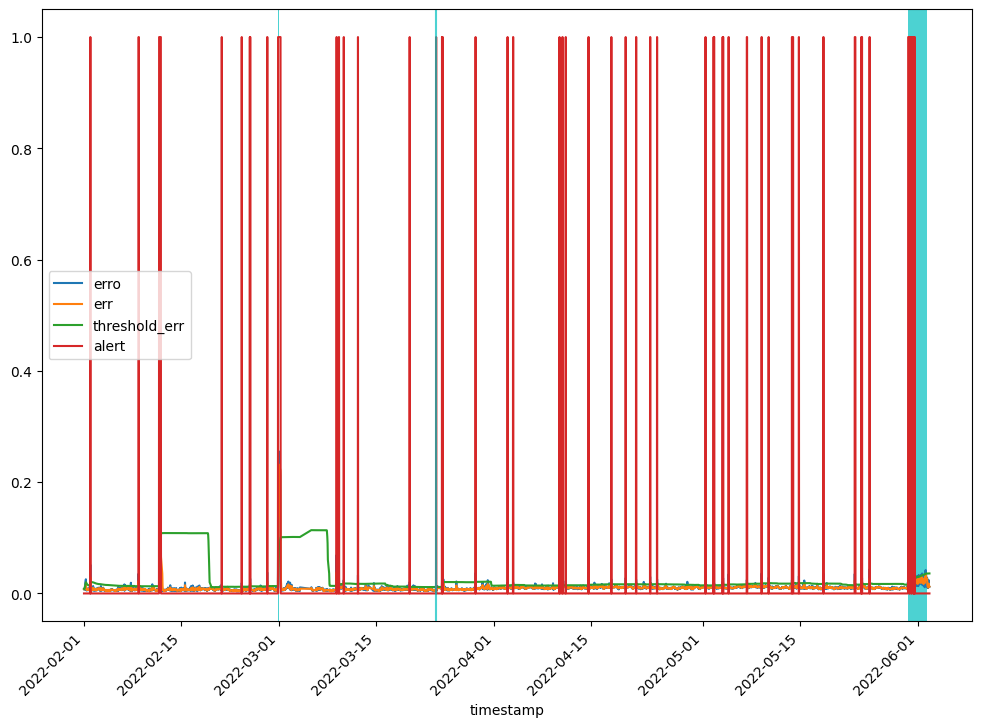

In [24]:
#TODO: mask anomalies that have been previously detected as anomalies
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

rolling_buffer = '7d'

recerr_agg_df['timestamp'] = recerr_agg_df['timestamp'].astype('datetime64[ns]')

err.loc[:, "threshold_err"] = (err.rolling(rolling_buffer).mean() + 3 * err.rolling(rolling_buffer).std())['err']
err['alert'] = (err['err'] > err['threshold_err']).astype(int)  #/2
err.plot(ax=ax)
ax.axvspan('2022-02-28 21:53:00', '2022-03-01 02:00:00', facecolor='c', alpha=0.7)
ax.axvspan('2022-03-23 14:54:00', '2022-03-23 15:24:00', facecolor='c', alpha=0.7)
ax.axvline('2022-03-23 14:54:00', color='c', alpha=0.7)
ax.axvspan('2022-05-30 12:00:00', '2022-06-02 06:18:00', facecolor='c', alpha=0.7)
plt.xticks(rotation=45)

In [25]:
err[err['alert'] > 0].shape

(121, 4)

(array([19024., 19038., 19052., 19066., 19083., 19097., 19113., 19127.,
        19144.]),
 [Text(19024.0, 0, '2022-02-01'),
  Text(19038.0, 0, '2022-02-15'),
  Text(19052.0, 0, '2022-03-01'),
  Text(19066.0, 0, '2022-03-15'),
  Text(19083.0, 0, '2022-04-01'),
  Text(19097.0, 0, '2022-04-15'),
  Text(19113.0, 0, '2022-05-01'),
  Text(19127.0, 0, '2022-05-15'),
  Text(19144.0, 0, '2022-06-01')])

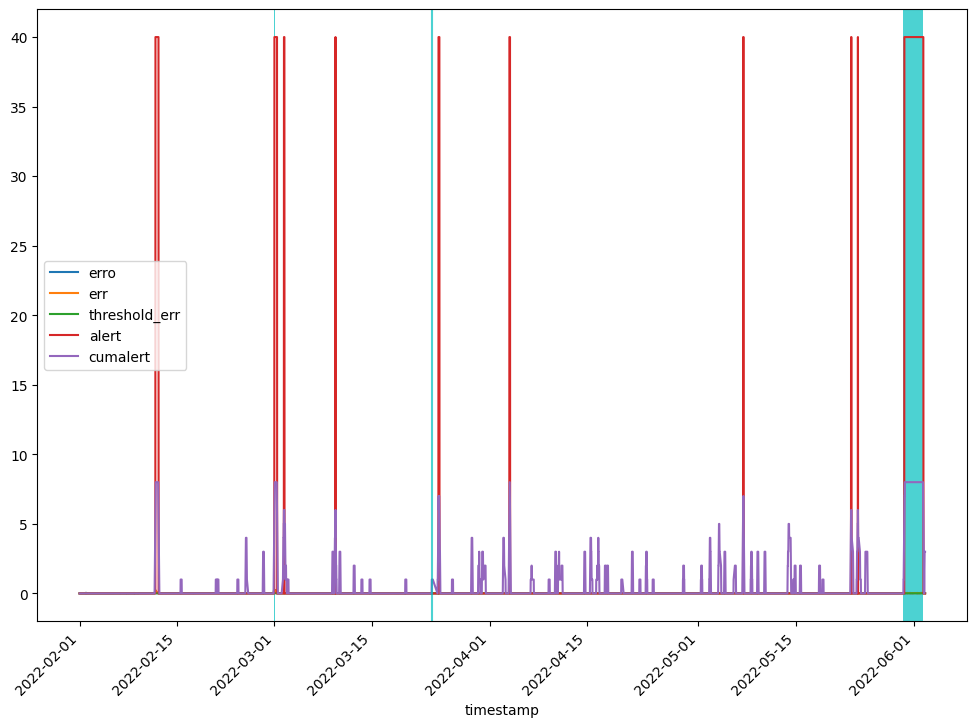

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

rolling_buffer = '7d'

err.loc[:, "threshold_err"] = 0
err.loc[:, "alert"] = 0
err.loc[:, "cumalert"] = 0
bufflen = int(2 * 24 * 7)  #sampels_per_hour * 24 * days
buffer = deque(maxlen=bufflen)
abufflen = int(2 * 4)  #samples_per_hour * monitoring_hours
alertbuf = deque(maxlen=abufflen)
for i, r in err.iterrows():
    if len(buffer) < bufflen:
        buffer.append(r['err'])
        continue
    avg = np.mean(buffer)
    sigma = np.std(buffer)
    if r['err'] > avg + 3 * sigma:
        err.loc[i, 'alert'] = 1
        alertbuf.append(1)
    else:
        alertbuf.append(0)
        buffer.append(r['err'])
    err.loc[i, 'cumalert'] = sum(alertbuf)

    if sum(alertbuf) >= 0.75 * abufflen:
        err.loc[i, 'alert'] = 40
    else:
        err.loc[i, 'alert'] = 0
    err.loc[i, "threshold_err"] = avg + 3 * sigma

err.plot(ax=ax)
ax.axvspan('2022-02-28 21:53:00', '2022-03-01 02:00:00', facecolor='c', alpha=0.7)
ax.axvspan('2022-03-23 14:54:00', '2022-03-23 15:24:00', facecolor='c', alpha=0.7)
ax.axvline('2022-03-23 14:54:00', color='c', alpha=0.7)
ax.axvspan('2022-05-30 12:00:00', '2022-06-02 06:18:00', facecolor='c', alpha=0.7)
plt.xticks(rotation=45)

([<matplotlib.axis.YTick at 0x7fb83cc9f460>,
 [Text(0, 0, 'TP2'),
  Text(0, 1, 'TP3'),
  Text(0, 2, 'H1'),
  Text(0, 3, 'DV_pressure'),
  Text(0, 4, 'Reservoirs'),
  Text(0, 5, 'Oil_temperature'),
  Text(0, 6, 'Flowmeter'),
  Text(0, 7, 'Motor_current'),
  Text(0, 8, 'COMP'),
  Text(0, 9, 'DV_eletric'),
  Text(0, 10, 'Towers'),
  Text(0, 11, 'MPG'),
  Text(0, 12, 'LPS'),
  Text(0, 13, 'Pressure_switch'),
  Text(0, 14, 'Oil_level'),
  Text(0, 15, 'Caudal_impulses')])

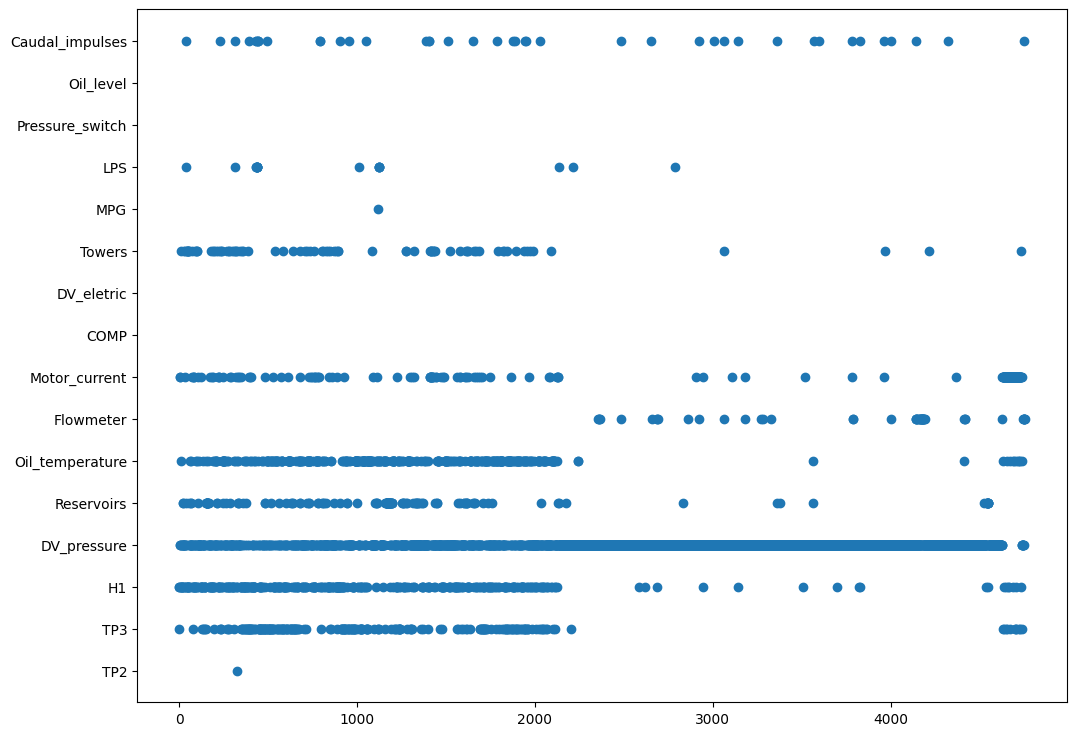

In [27]:
#last results form window of 180, 128 units, kernels 16-size (previously kernels 7)
plt.figure(figsize=(12, 9))
plt.scatter(np.arange(0, len(recerr_agg_idx)), recerr_agg_idx)
ticks = realdata.columns[1:]
plt.yticks(np.arange(len(ticks)), ticks)

In [28]:
sensor_err = np.mean(np.abs(recerr), axis=1)
sensorerr_agg_df = pd.DataFrame(sensor_err, columns=features)
sensorerr_agg_df['timestamp'] = timestamps
sensorerr_agg_df = sensorerr_agg_df.set_index('timestamp')

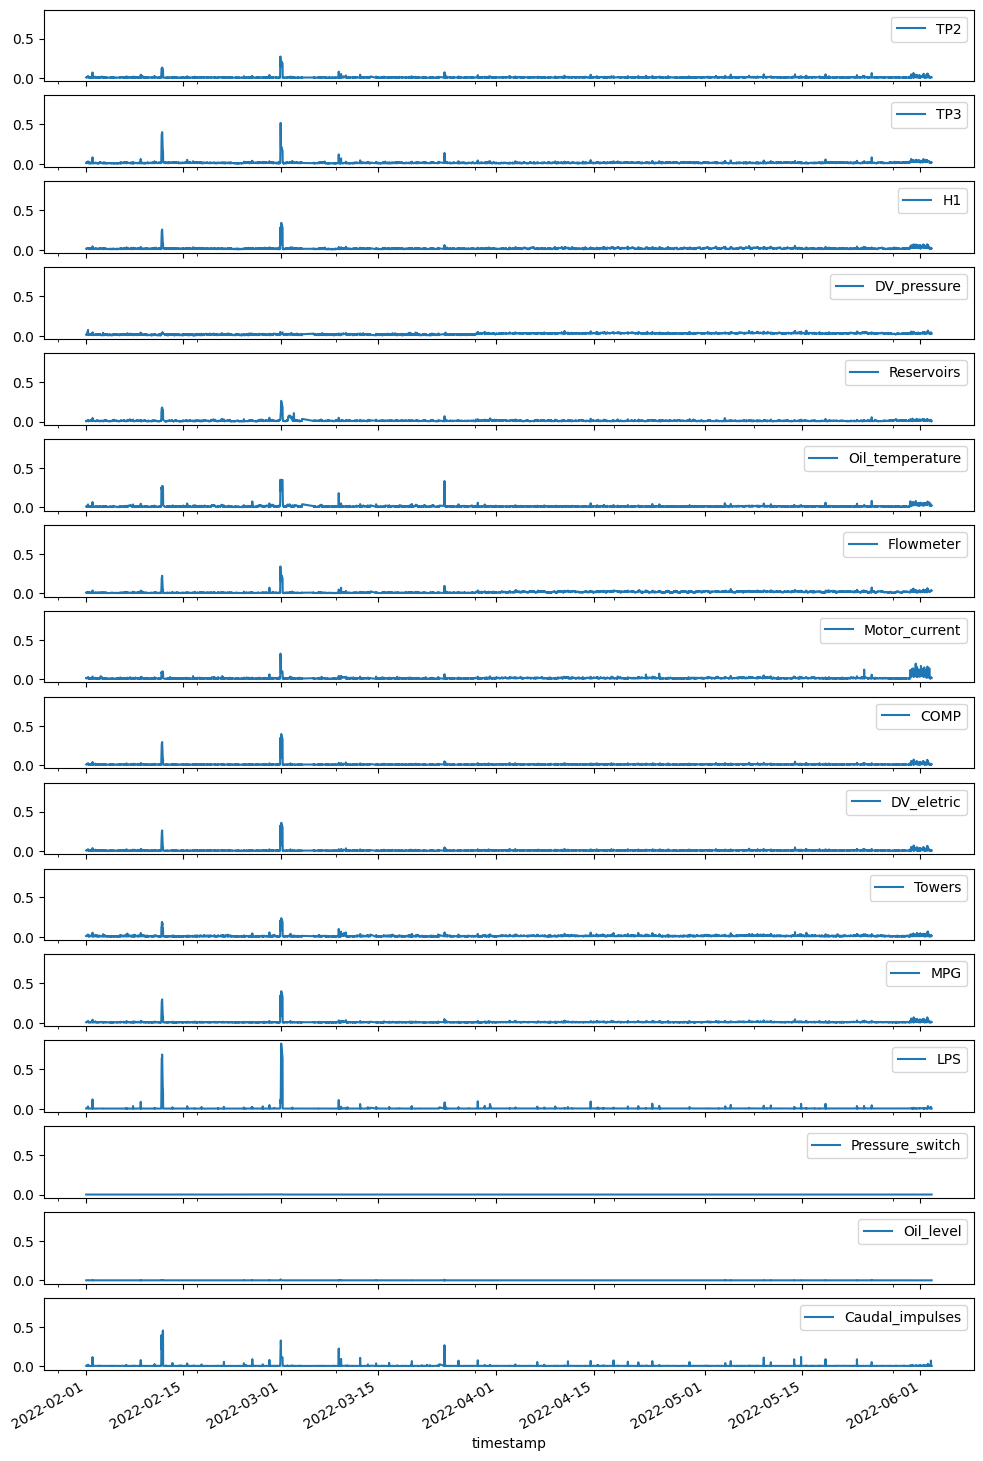

In [29]:
fig, axs = plt.subplots(len(features), figsize=(12, 20), sharex=True, sharey=True)
for i, f in enumerate(features):
    sensorerr_agg_df[[f]].plot(ax=axs[i])

## Classifier

In [30]:
breaks = err['alert'] - err['alert'].shift(-1)
separate_alerts = breaks[breaks < 0]
separate_alerts

timestamp
2022-02-11 21:19:00   -40.0
2022-03-01 00:02:00   -40.0
2022-03-02 09:00:00   -40.0
2022-03-09 18:57:00   -40.0
2022-03-24 14:33:00   -40.0
2022-04-03 19:24:00   -40.0
2022-05-07 10:20:00   -40.0
2022-05-22 23:05:00   -40.0
2022-05-23 22:34:00   -40.0
2022-05-30 14:57:00   -40.0
Name: alert, dtype: float64

In [31]:
erri = err.reset_index()
Xerr = erri[erri['alert'] > 0]
Xset = erri[erri['cumalert'] == 0].sample(len(Xerr))

dsidxerr = list(Xerr.index)
dsixnormal = list(Xset.index)

cl_inputX = np.concatenate((realX[dsidxerr, :, :], realX[dsixnormal, :, :]))
cl_inputy = to_categorical(np.concatenate((np.ones(len(Xerr)), np.zeros(len(Xset)))))

In [32]:
fXtrain, fXtest, ftrainy, ftesty = train_test_split(cl_inputX, cl_inputy, shuffle=False)

In [78]:
encoder.trainable = True

In [67]:
encoder.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ reshape_8 (Reshape)             │ (None, 3, 10, 16)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv_lstm1d_8 (ConvLSTM1D)      │ (None, 3, 10, 64)         │    225,536 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv_lstm1d_9 (ConvLSTM1D)      │ (None, 3, 10, 32)         │    135,296 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 360,832 (1.38 MB)

 Trainable params: 360,832 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# model_classifier = load_model(f'shared/metropt/model_classifier_v8_fun.h5')
model_classifier = load_model(f'shared/metropt/model_classifier_v9_seq.h5')

2024-01-19 08:55:36.215512: W tensorflow/c/c_api.cc:304] Operation '{name:'conv_lstm1d_7_2/recurrent_kernel/Assign' id:4055 op device:{requested: '', assigned: ''} def:{{{node conv_lstm1d_7_2/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv_lstm1d_7_2/recurrent_kernel, conv_lstm1d_7_2/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-19 08:55:36.488343: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_5/kernel/m/Assign' id:4634 op device:{requested: '', assigned: ''} def:{{{node dense_5/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_5/kernel/m, dense_5/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was ru

In [32]:
#same data, because we just want to interpret what has been learnt
accuracy, model_classifier = train_classifier_model_functional(
    fXtrain, ftrainy, fXtrain, ftrainy, encoder)
encoder.trainable = False
print(f"accuracy= {accuracy}")
model_classifier.save(f'shared/metropt/model_classifier_v8_fun.h5', save_format='h5')
model_classifier

2024-01-18 12:29:50.346459: W tensorflow/c/c_api.cc:304] Operation '{name:'training_2/Adam/conv_lstm1d_1_1/kernel/v/Assign' id:6491 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/conv_lstm1d_1_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/conv_lstm1d_1_1/kernel/v, training_2/Adam/conv_lstm1d_1_1/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-18 12:29:50.940589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-18 12:29:52.959239: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_1/mul' id:4588 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_F

accuracy= 0.991150438785553


In [85]:
#same data, because we just want to interpret what has been learnt
accuracy, model_classifier = train_classifier_model_sequential(
    fXtrain, ftrainy, fXtrain, ftrainy, encoder)
print(f"accuracy= {accuracy}")
model_classifier.save(f'shared/metropt/model_classifier_v9_seq.h5', save_format='h5')
model_classifier

2024-01-18 13:42:27.811055: W tensorflow/c/c_api.cc:304] Operation '{name:'training_12/Adam/dense_6/bias/v/Assign' id:33668 op device:{requested: '', assigned: ''} def:{{{node training_12/Adam/dense_6/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_12/Adam/dense_6/bias/v, training_12/Adam/dense_6/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-18 13:42:30.853707: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_7/mul' id:31741 op device:{requested: '', assigned: ''} def:{{{node loss_7/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_7/mul/x, loss_7/dense_8_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in 

accuracy= 1.0


In [86]:
predicted = model_classifier.predict(fXtrain)
predicted

2024-01-18 13:42:32.694606: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_8/Softmax' id:31665 op device:{requested: '', assigned: ''} def:{{{node dense_8/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_8/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


array([[1.08194157e-17, 1.00000000e+00],
       [2.06782365e-17, 1.00000000e+00],
       [2.20006187e-17, 1.00000000e+00],
       [1.77026925e-17, 1.00000000e+00],
       [2.19580272e-17, 1.00000000e+00],
       [1.43259079e-17, 1.00000000e+00],
       [3.08110683e-17, 1.00000000e+00],
       [9.60853579e-18, 1.00000000e+00],
       [6.63357368e-03, 9.93366420e-01],
       [9.47797857e-03, 9.90522027e-01],
       [3.28479201e-01, 6.71520829e-01],
       [5.31444093e-03, 9.94685531e-01],
       [5.53235337e-02, 9.44676459e-01],
       [2.50376691e-03, 9.97496188e-01],
       [1.68105093e-18, 1.00000000e+00],
       [1.77430448e-18, 1.00000000e+00],
       [1.98928066e-18, 1.00000000e+00],
       [6.59289108e-19, 1.00000000e+00],
       [4.37247800e-05, 9.99956250e-01],
       [9.52255726e-03, 9.90477443e-01],
       [1.83611247e-03, 9.98163879e-01],
       [4.25029111e-06, 9.99995708e-01],
       [7.55466148e-02, 9.24453318e-01],
       [1.49622159e-02, 9.85037744e-01],
       [1.641962

In [87]:
f1_score(np.argmax(ftrainy, axis=1), np.argmax(predicted, axis=1))

1.0

### Shap

In [83]:
shap_version = 'deep'
bg_size = 1000
absshap = True
if shap_version == 'window':
    print(window_len)  # Only for SlidingWindowSHAP
    #There is a problem with Windowed version for more than two classes
    indexes = np.arange(0, len(fXtrain))
    np.random.shuffle(indexes)
    maxid = min(bg_size, len(fXtrain))
    background_data = fXtrain[indexes[:maxid]]

    sv_ts = np.zeros((len(fXtrain), fXtrain.shape[1], fXtrain.shape[2]))
    sv_tr = np.zeros((len(fXtrain), fXtrain.shape[1], fXtrain.shape[2]))

    for i in range(len(fXtrain)):
        gtw = SlidingWindowSHAP(model_classifier, stride, window_len, background_data, fXtrain[i:i + 1], model_type='lstm')
        sv_ts[i, :, :] = gtw.shap_values(num_output=ftrainy.shape[1])
    for i in range(len(fXtrain)):
        gtw = SlidingWindowSHAP(model_classifier, stride, window_len, background_data, fXtrain[i:i + 1], model_type='lstm')
        sv_tr[i, :, :] = gtw.shap_values(num_output=ftrainy.shape[1])
        
if shap_version == 'deep':
    indexes = np.arange(0, len(fXtrain))
    np.random.shuffle(indexes)
    maxid = min(bg_size, len(fXtrain))
    background_data = fXtrain[indexes[:maxid]]

    explainer = shap.DeepExplainer(model_classifier, background_data)
    shap_values_ts = explainer.shap_values(fXtrain, check_additivity=False)
    shap_values_tr = explainer.shap_values(fXtrain, check_additivity=False)
    if absshap:
        sv_ts = abs(np.array(shap_values_ts)).mean(
            axis=0)  # This basically returns the average importance over the feature/sample
        # Not taking into account the sign of shap value, as it is not required
        # for breakpoints calculation
        sv_tr = abs(np.array(shap_values_tr)).mean(
            axis=0)  # This basically returns the average importance over the feature/sample
        # Not taking into account the sign of shap value, as it is not required
        # for breakpoints calculation
    else:
        indexer = np.argmax(model_classifier.predict(fXtrain), axis=1)
        sv_ts = []
        for i in range(0, len(fXtrain)):
            sv_ts.append([shap_values_ts[indexer[i]][i, :]])
        sv_ts = np.concatenate(sv_ts)
        indexer = np.argmax(model_classifier.predict(fXtrain), axis=1)
        sv_tr = []
        for i in range(0, len(fXtrain)):
            sv_tr.append([shap_values_tr[indexer[i]][i, :]])
        sv_tr = np.concatenate(sv_tr)

In [84]:
# save_to_pickle(shap_values_ts, "shap_values_ts_v8_fun.pkl", directory=DATA_DIRECTORY) 
# save_to_pickle(shap_values_tr, "shap_values_tr_v8_fun.pkl", directory=DATA_DIRECTORY) 
# save_to_pickle(sv_ts, "sv_ts_absshap_true_v8_fun.pkl", directory=DATA_DIRECTORY) 
# save_to_pickle(sv_tr, "sv_tr_absshap_true_v8_fun.pkl", directory=DATA_DIRECTORY) 

save_to_pickle(shap_values_ts, "shap_values_ts_v9_seq.pkl", directory=DATA_DIRECTORY) 
save_to_pickle(shap_values_tr, "shap_values_tr_v9_seq.pkl", directory=DATA_DIRECTORY) 
save_to_pickle(sv_ts, "sv_ts_absshap_true_v9_seq.pkl", directory=DATA_DIRECTORY) 
save_to_pickle(sv_tr, "sv_tr_absshap_true_v9_seq.pkl", directory=DATA_DIRECTORY) 

Saved to shared/metropt/shap_values_ts_v9_seq.pkl
Saved to shared/metropt/shap_values_tr_v9_seq.pkl
Saved to shared/metropt/sv_ts_absshap_true_v9_seq.pkl
Saved to shared/metropt/sv_tr_absshap_true_v9_seq.pkl
